## Fixed income: python code (Q1, Q2, Q4, Q5)

In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline

# Import the bonds data
data_ex1 = pd.read_excel('/Users/ilyas/Library/CloudStorage/OneDrive-Personnel/EDHEC/M2/Advanced Fixed Income/Group Assignment/Data Assignment.xls',sheet_name=1, header=2)
data_ex4 = pd.read_excel('/Users/ilyas/Library/CloudStorage/OneDrive-Personnel/EDHEC/M2/Advanced Fixed Income/Group Assignment/Data Assignment.xls',sheet_name=2, header=2)

# Deleting NA values and setting the maturity date as the index
data_ex1 = data_ex1.dropna()
data_ex1 = data_ex1.set_index('Maturity Date')
data_ex1.index = pd.to_datetime(data_ex1.index, infer_datetime_format=True)

# Adding the maturity data to the dataframe
data_ex1['Maturity'] = np.arange(0.5,(len(data_ex1)+1)/2,0.5)
data_ex1.head()

,Coupon Rate (%),Current Price,Maturity
Maturity Date,,,
2004-02-15,3,101.0544,0.5
2004-08-15,2.125,100.9254,1.0
2005-02-15,1.5,99.8942,1.5
2005-08-15,6.5,109.0934,2.0
2006-02-15,5.625,108.4380,2.5


# Question 1: Bootstrapping

## Question 1

From the bond prices and coupon rates, we can compute the price of a zero coupon bond. For this, we define a cashflow matrix ```cashflow```. We then invert this matrix and multiply it with the ```Current Price``` vector to get the price of a zero coupon bond.

In [2]:
## COMPUTATION OF THE ZERO-COUPON BOND PRICES

# Initialise the cashflow matrix
cashflow = np.zeros((len(data_ex1),len(data_ex1)))

# Add the first value manually, as it is a lump sum composed of the coupon and par value
cashflow[0,0] = data_ex1['Coupon Rate (%)'].iloc[0]/2 + 100

# Fill in the cashflow matrix, assuming semi-annual cashflow and $100 par value
for i in range(1,len(data_ex1)):
    cashflow[i,:i] = data_ex1['Coupon Rate (%)'].iloc[i]/2
    cashflow[i,i] = (data_ex1['Coupon Rate (%)'].iloc[i]/2) + 100

# Store the price data separately
price = data_ex1['Current Price']

# Invert the cashflow matrix
cashlow_inv = np.linalg.inv(cashflow)

# Computation of the price of the zero-coupon  bonds
data_ex1['Price Zero Coupon Bond'] = cashlow_inv @ price
data_ex1.head()

,Coupon Rate (%),Current Price,Maturity,Price Zero Coupon Bond
Maturity Date,,,,
2004-02-15,3,101.0544,0.5,0.995610
2004-08-15,2.125,100.9254,1.0,0.988176
2005-02-15,1.5,99.8942,1.5,0.976738
2005-08-15,6.5,109.0934,2.0,0.963406
2006-02-15,5.625,108.4380,2.5,0.947375


From the price of a zero coupon bond, we can compute the zero-coupon yield using the following formula:
$$ Yld = 2\times (Price^{-\frac{1}{2\times Mat}}-1)$$

In [3]:
## COMPUTATION OF THE ZERO-COUPON YIELD
data_ex1['Zero Coupon Yield'] =  2 * (data_ex1['Price Zero Coupon Bond']**(-1/(2*data_ex1['Maturity']))-1)

data_ex1.head()

,Coupon Rate (%),Current Price,Maturity,Price Zero Coupon Bond,Zero Coupon Yield
Maturity Date,,,,,
2004-02-15,3,101.0544,0.5,0.995610,0.008819
2004-08-15,2.125,100.9254,1.0,0.988176,0.011930
2005-02-15,1.5,99.8942,1.5,0.976738,0.015753
2005-08-15,6.5,109.0934,2.0,0.963406,0.018727
2006-02-15,5.625,108.4380,2.5,0.947375,0.021742


## Question 2

We substract the yields from the model from the zero-coupon yields we computed in question 1.

In [4]:
## PREPARING THE DATA
# Deleting NA values 
data_ex4 = data_ex4.dropna()

# Extracting the maturity as a float, the BEY as a float
data_ex4['Maturity'] =  data_ex4['Maturity (years)'].replace({'y':''}, regex=True)
data_ex4 = data_ex4.astype({'Maturity':'float'})

data_ex4['Model Prediction (BEY)'] =  data_ex4['Model Prediction (BEY)'].replace({'%':''}, regex=True)
data_ex4 = data_ex4.astype({'Model Prediction (BEY)':'float'})

# Saving the orifinal data_ex1 dataframe
zero_coup = data_ex1

# Setting the maturity as a common index for both dataframes
data_ex1 = data_ex1.set_index('Maturity')
data_ex4 = data_ex4.set_index('Maturity')

# Saving the zero-coupon yields for the same maturity as those from the data of the exhibit 4
data_ex4['Zero Coupon Yield'] = data_ex1.loc[data_ex4.index, 'Zero Coupon Yield']

In [5]:
## COMPARING THE COMPUTED YIELD TO THE YIELD FROM THE MODEL

# Multiplying the zero coupon yield by 100 to obtain percents and looking at the difference
data_ex4['Difference in Yields'] = data_ex4['Zero Coupon Yield']*100 - data_ex4['Model Prediction (BEY)']

# Giving recommendation depending on the sign of the difference
data_ex4['Recommendation'] = np.where(data_ex4['Zero Coupon Yield'] < data_ex4['Model Prediction (BEY)'], 'Sell',
                                       np.where(data_ex4['Zero Coupon Yield'] > data_ex4['Model Prediction (BEY)'],'Buy',
                                                ''
                                               )
                                      )
data_ex4

,Maturity (years),Model Prediction (BEY),Zero Coupon Yield,Difference in Yields,Recommendation
Maturity,,,,,
1.0,1y,1.2443,0.011930,-0.051338,Sell
2.0,2y,1.8727,0.018727,0.000018,Sell
3.0,3y,2.4110,0.024711,0.060112,Sell
4.0,4y,2.9665,0.030084,0.041878,Sell
5.0,5y,3.4454,0.034799,0.034514,Sell
6.0,6y,3.8557,0.038817,0.026011,Sell
7.0,7y,4.1996,0.042203,0.020736,Sell
8.0,8y,4.4677,0.044865,0.018830,Sell
9.0,9y,4.6528,0.046640,0.011171,Sell


Since there's an inverse proportionality between prices and interest rates, when the interest rate from the DB model is higher than the actual one computed later, it means that the bond is overpriced, so the recommendation would be to sell that specific bond. On the other hand, when the model estimated lower interest rates with respect to the actual one, it is the exact opposite, and the bond is underpriced. So, it makes sense to buy the bond, since the price will be lower than expected and the bond will have a higher return.

## Question 3

No, because the model used works under the no-arbitrage condition. The prices and yields are computed so that there is not the space for an investor to buy a risk-free arbitrage portfolio.

# Question 2: Cubic Splines

## Question 1

We define manually the knot points composed of a maturity part and the associated zero-coupon yield computed in the question 1.
We then use the CubicSpline function from the scipy.interpolate library to compute the associated cubic splines.

In [6]:
## CALCULATING THE CUBIC SPLINES
# Calculate 5 natural cubic spline polynomials for 5 maturity points
maturity_pt = np.array([2,5,10,15,20])
zero_coup_yld = np.array([0.018727,0.034799,0.047107,0.057167,0.059513])

# Calculate natural cubic spline polynomials
cs = CubicSpline(maturity_pt,zero_coup_yld,bc_type='natural')

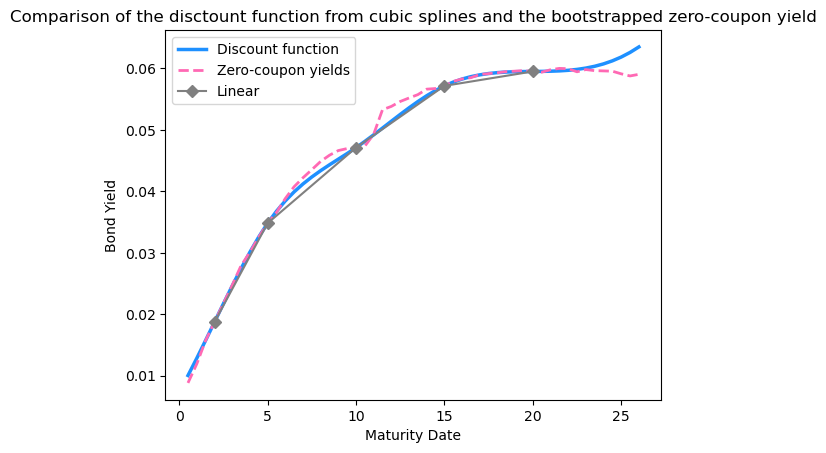

In [7]:
## PLOTTING THE RESULTS

mat = np.arange(0.5, 26.5, 0.5) # maturity dates

# Knots
m_pt = np.array([2, 5, 10, 15, 20])
zero_coup_yld = np.array([0.018727177, 0.034799136, 0.047106836, 0.057166841, 0.059513023])

plt.plot(mat,cs(mat),c='dodgerblue', label='Discount function', linewidth=2.5)
plt.plot(mat,zero_coup['Zero Coupon Yield'], '--',c='hotpink', label='Zero-coupon yields',linewidth=2)
plt.plot(m_pt, zero_coup_yld, c='grey', marker='D', label='Linear')

plt.ylabel('Bond Yield')
plt.xlabel('Maturity Date')
plt.title('Comparison of the disctount function from cubic splines and the bootstrapped zero-coupon yield')
plt.legend()
plt.show()

## Question 2

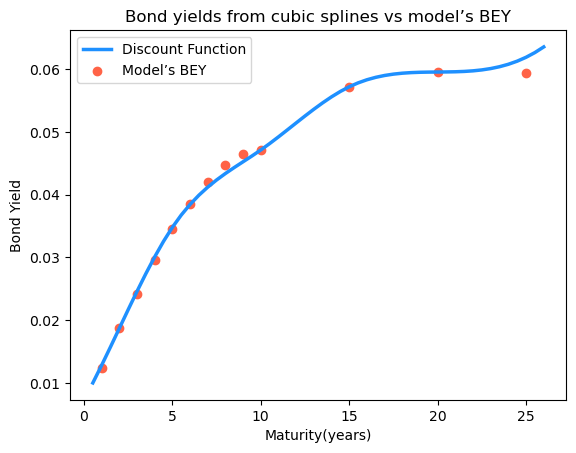

In [8]:
## PLOT THE CS CURVE QND THE BEY
plt.plot(mat,cs(mat),c='dodgerblue', label='Discount Function', linewidth=2.5)
m_mkt = np.array([1,2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25])
BEY = np.array([0.012443, 0.018727, 0.02411, 0.029665, 0.034454, 
                0.038557, 0.041996, 0.044677, 0.046528, 0.047107, 
                0.05716, 0.059517, 0.059315]) 
plt.scatter(m_mkt, BEY, c='tomato', label='Model’s BEY')
plt.ylabel('Bond Yield')
plt.xlabel('Maturity(years)')
plt.title('Bond yields from cubic splines vs model’s BEY')
plt.legend()
plt.show()

In [9]:
data = pd.DataFrame(cs(mat)*100)
data = data.set_index(mat)

data_ex4['Bond Yield CS (%)'] = data.loc[data_ex4.index,0]
data_ex4['Difference in Yields CS (%)'] = data_ex4['Bond Yield CS (%)'] - data_ex4['Model Prediction (BEY)']

f = lambda v: 'background-color: %s' % 'dodgerblue' if v>0 else ''
dp = pd.DataFrame(data_ex4['Difference in Yields CS (%)']).style.applymap(f)
dp

,Difference in Yields CS (%)
Maturity,
1.000000,0.040327
2.000000,0.000000
3.000000,0.049773
4.000000,0.043092
5.000000,0.034500
6.000000,-0.011810
7.000000,-0.080059
8.000000,-0.131424
9.000000,-0.129279


So we will sell the zero-coupon bonds with maturity of 6, 7, 8, 9, 10 and 20 years and buy all the other zero-coupon bonds.

## Question 3

In [10]:
## CALCULATING THE CUBIC SPLINES
# Calculate 5 natural cubic spline polynomials for 2 maturity points
maturity_pt2 = np.array([5,20])
zero_coup_yld2 = np.array([0.034799,0.059513])

# Calculate natural cubic spline polynomials
cs2 = CubicSpline(maturity_pt2,zero_coup_yld2,bc_type='natural')

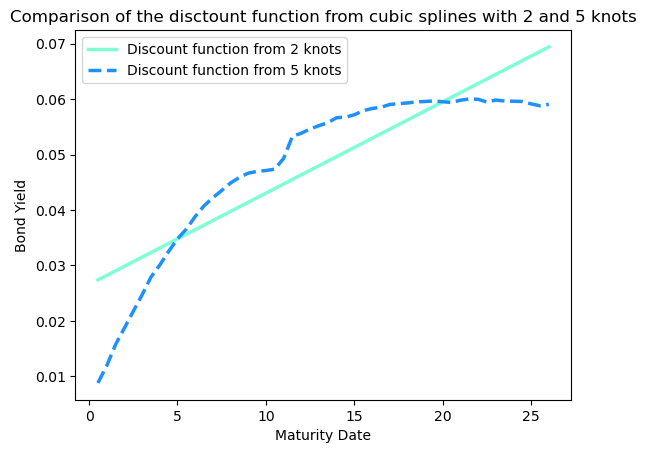

In [11]:
## PLOTTING THE RESULTS AND COMPARING TO THE PREVIOUS RESULTS
plt.plot(mat,cs2(mat),c='aquamarine', label='Discount function from 2 knots', linewidth=2.5)
plt.plot(mat,zero_coup['Zero Coupon Yield'], '--',c='dodgerblue', label='Discount function from 5 knots',linewidth=2.5)
plt.ylabel('Bond Yield')
plt.xlabel('Maturity Date')
plt.title('Comparison of the disctount function from cubic splines with 2 and 5 knots')
plt.legend()
plt.show()

Going from 5 knots to 2 knots deteriorates materially the estimation of the discount function, which goes from a complex curve to a simple line.

# Question 4: Hedging

## Question 1

In [12]:
## COMPUTE THE CUBIC SPLINES
# Define the 5 knots when the 10-year yield is shocked
maturity_pt = np.array([2,5,10,15,20])
zero_coup_yld = np.array([0.018727,0.034799,0.047107+0.005,0.057167,0.059513])

# Calculate natural cubic spline polynomials
cs3 = CubicSpline(maturity_pt,zero_coup_yld,bc_type='natural')

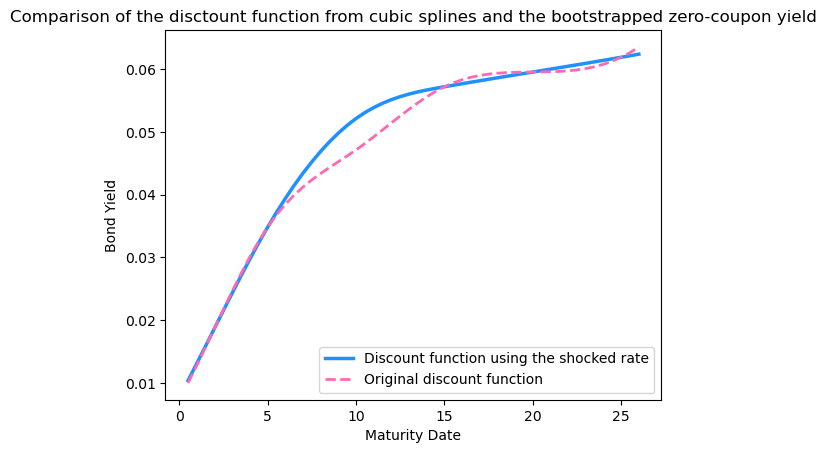

In [13]:
## PLOT THE RESULTS
plt.plot(mat,cs3(mat),c='dodgerblue', label='Discount function using the shocked rate', linewidth=2.5)
plt.plot(mat,cs(mat), '--',c='hotpink', label='Original discount function',linewidth=2)
plt.ylabel('Bond Yield')
plt.xlabel('Maturity Date')
plt.title('Comparison of the disctount function from cubic splines and the bootstrapped zero-coupon yield')
plt.legend()
plt.show()

We notice that there is a bump in the yield at the shocked rate, and this has an impact on the end of the curve too.

## Question 2

We use the yield curve from the cubic splines of the previous question to discount the cashflow of each bond and get their new price. We use these prices to compute the difference in value of of an equally weighted portfolio.

In [14]:
## COMPUTE THE KEY DURATION
# Store the shocked yield curve
shocked_yields = cs3(mat)

# Compute the amount of each bond held in an equally weighted portfolio
dollar_per_bond =(10**6)/len(mat)
amt_per_bond = dollar_per_bond/data_ex1['Current Price']

# Compute the present value of the portfolio with the shocked yield curve
cashflow_shock = np.zeros((len(cashflow),len(cashflow)))
for i in range(len(cashflow)):
    cashflow_shock[:,i] = cashflow[:,i] / ((1 + shocked_yields[i]/2)**((i+1)))
prices = np.sum(cashflow_shock, axis=1)

# Compute the difference between the original  value of the portfolio and its new present value
KRD = np.sum(amt_per_bond * prices) - (10**6)
KRD/(10**6)

-0.008565486989634578

## Question 3

Using the Nelson Siegel Svensson model, we compute the yield curve when shocking each yield individually. We then use it to price each bond by discounting its cashflow. We finally store the difference between the original value of the equally weigthed portfolio and its new value after the shock in yields.

In [15]:
## NSS Model from Q3
## ESTIMATE THE MODEL PARAMETERS

# Compute the yields according to the model
def NSS(coeffs):
    # Unpack the parameters
    b0, b1, b2, b3, theta, nv = coeffs
    
    # Initialise the yields vector
    ylds = np.zeros(52)
    
    # Compute the model yield for every maturity and store it in the vector ylds
    for t in np.arange(0.5,26.5,0.5):
        rate = b0 + b1 * ((1 - np.exp(-t/theta)) / (t/theta)) + b2 * (((1 - np.exp(-t/theta)) / (t/theta))- np.exp(-t/theta)) + b3 * (((1 - np.exp(-t/nv))/ (t/nv)) - np.exp(-t/nv))
        k = int(t*2-1)
        ylds[k] = rate
        
    return ylds

# Function to minimise
def sum_of_squares(coeff, Y):
    yields = NSS(coeff)
    yields_series = np.array(Y)
    obj = np.array(((yields - yields_series)**2)).sum()
    return obj

# Numerical minimisation
guess = [0.01,0.01,0.01,0.01,2,3] # initial guess

In [16]:
## COMPUTING THE KRD FOR EACH YIELD

# Initialising the KRD matrix
KRD_mat = np.zeros(len(mat))

for i in range(len(mat)):
    # Saving the original yield
    shock_yield2 = zero_coup['Zero Coupon Yield'].copy()
    
    # Shocking the i-th yield
    shock_yield2.iloc[i] += 0.005
    
    # Estimating the parameter models using the shocked yield curve
    res = minimize(sum_of_squares, [0.01,0.01,0.01,0.01,2,3], args=(shock_yield2), options={'disp':False}).x
    
    # Storing the yields for each maturity
    yld = NSS(res)

    # Computing the new price of each bond
    cashflow_shock = np.zeros((len(cashflow),len(cashflow)))
    for t in range(len(cashflow)):
        cashflow_shock[:,t] = cashflow[:,t] / ((1 + yld[t]/2)**((t+1)))
    prices = np.sum(cashflow_shock, axis=1)
    
    # Storing the KRD when shocking the i-th yield individually
    KRD_mat[i] =( np.sum(amt_per_bond * prices) - (10**6))/(10**6)

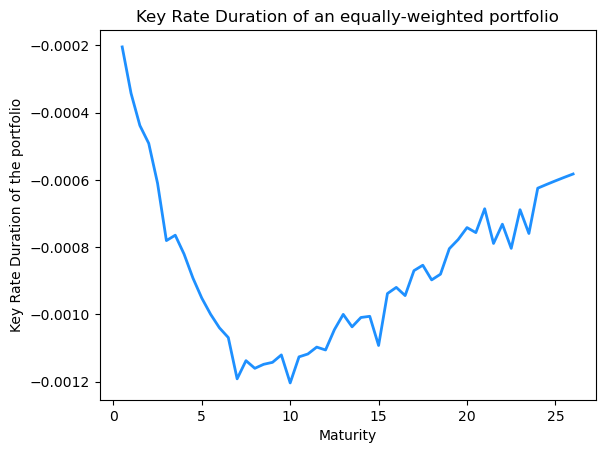

In [17]:
## PLOTTING THE RESULTS
plt.plot(mat,KRD_mat, c='dodgerblue',linewidth=2)
plt.title('Key Rate Duration of an equally-weighted portfolio')
plt.xlabel('Maturity')
plt.ylabel('Key Rate Duration of the portfolio')
plt.show()

# Question 5: Portfolio Strategy

## Question 1

In [18]:
## COMPUTING THE NEW YIELDS

# Keeping the relevant columns
z_coup_expect = zero_coup[['Maturity','Zero Coupon Yield']].copy()

# Setting the random seed for reproducible results
np.random.seed(123)

# Computing the average maturity of our sample
T_bar = z_coup_expect['Maturity'].mean()
std = 0.0025

# Defining the steepening function
def steep(yld, tbar,mat):
    y_steep = yld + (0.005*(mat-tbar)/tbar)
    return float(y_steep)

# Applying the steepening function to the zero-coupon yields computed in Q1.2
z_coup_expect['Random Component'] = np.random.normal(0,std,len(z_coup_expect))
z_coup_expect['Deterministic Component'] = z_coup_expect.apply(lambda z_coup_expect: steep(z_coup_expect['Zero Coupon Yield'],T_bar, z_coup_expect['Maturity']), axis=1)
z_coup_expect['Steepened Yield'] = z_coup_expect['Deterministic Component'] +z_coup_expect['Random Component']
z_coup_expect.head()  

,Maturity,Zero Coupon Yield,Random Component,Deterministic Component,Steepened Yield
Maturity Date,,,,,
2004-02-15,0.5,0.008819,-0.002714,0.004008,0.001294
2004-08-15,1.0,0.011930,0.002493,0.007307,0.009800
2005-02-15,1.5,0.015753,0.000707,0.011319,0.012026
2005-08-15,2.0,0.018727,-0.003766,0.014482,0.010716
2006-02-15,2.5,0.021742,-0.001447,0.017685,0.016239


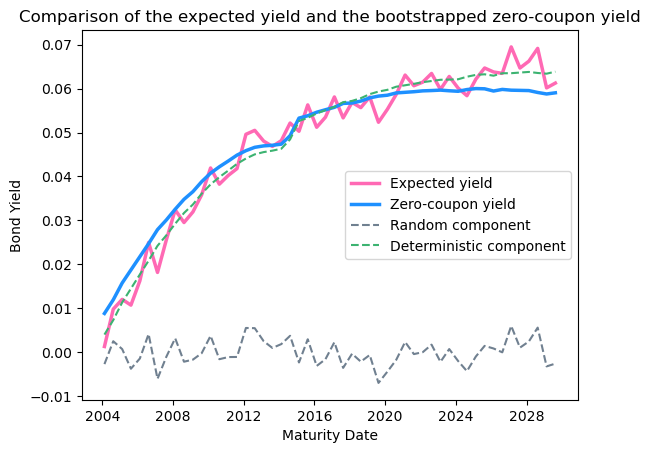

In [19]:
## PLOTTING THE RESULTS
plt.plot(z_coup_expect['Steepened Yield']*1, c='hotpink', label='Expected yield',linewidth=2.5)
plt.plot(z_coup_expect['Zero Coupon Yield']*1, c='dodgerblue', label='Zero-coupon yield', linewidth=2.5)
plt.plot(z_coup_expect['Random Component'], '--',c='slategray', label='Random component')
plt.plot(z_coup_expect['Deterministic Component'],'--',c='mediumseagreen', label='Deterministic component')
plt.ylabel('Bond Yield')
plt.xlabel('Maturity Date')
plt.title('Comparison of the expected yield and the bootstrapped zero-coupon yield')
plt.legend()
plt.show()

## Question 2

In [20]:
## COMPUTE THE NEW BOND PRICES

# Estimate the parameters of the Nelson-Siegel-Svensson model using the Steepend yield curve
res = minimize(sum_of_squares, [0.01,0.01,0.01,0.01,2,2], args=(z_coup_expect['Steepened Yield']), options={'disp':False})

# Store the new yield curv
yields = NSS(res.x)

# Compute the new prices by discounting the cashflows
cashflow_exp = np.zeros((len(cashflow),len(cashflow)))

for i in range(len(cashflow)):
    cashflow_exp[:,i] = cashflow[:,i] / ((1 + yields[i]/2)**((i+1)))

prices = np.sum(cashflow_exp, axis=1)

In [21]:
## COMPARING THE PRICES AND DISPLAYING THE RESULTS
newprices = pd.DataFrame(data_ex1['Current Price'])
newprices['Prices from steepened curve'] = prices
newprices['Difference in price'] = newprices['Prices from steepened curve'] - newprices['Current Price']
newprices.to_excel('prices.xlsx', sheet_name='s')
newprices.head()

,Current Price,Prices from steepened curve,Difference in price
Maturity,,,
0.5,101.0544,101.338124,0.283724
1.0,100.9254,101.443299,0.517899
1.5,99.8942,100.700522,0.806322
2.0,109.0934,110.123010,1.029610
2.5,108.4380,109.622363,1.184363


## Question 3

In [22]:
# Divide into 2 different data frames expensive and cheap bonds
newprices['C/E'] = np.where(newprices['Difference in price']>0, 'Cheap',
                                       np.where(newprices['Difference in price']<0,'Expensive',
                                                ''
                                               )
                                      )
c_bonds = newprices[newprices['C/E'] == 'Cheap'].copy()
e_bonds = newprices[newprices['C/E'] == 'Expensive'].copy()

## Compute weights based on the mispricing in the bonds, so that the weights sum up to 1
# Cheap
Delta_cheap = c_bonds['Difference in price'].sum()
c_bonds['Weight'] = c_bonds['Difference in price'] / Delta_cheap

# Expensive
Delta_expensive = - e_bonds['Difference in price'].sum()
e_bonds['Weight'] = e_bonds['Difference in price'] / Delta_expensive

# Initial wealth: 100$
Wealth = 100
# short
c_bonds['Inv'] = c_bonds['Weight'] * Wealth
e_bonds['Inv'] = e_bonds['Weight'] * Wealth

# Compute Returns for each bond
c_bonds['Return'] = c_bonds['Difference in price']/c_bonds['Current Price']
e_bonds['Return'] = e_bonds['Difference in price']/e_bonds['Current Price']

# Store the results in a dataframe
strategy = pd.concat([e_bonds, c_bonds], ignore_index=False)
strategy = strategy.sort_values(by='Maturity')
strategy

,Current Price,Prices from steepened curve,Difference in price,C/E,Weight,Inv,Return
Maturity,,,,,,,
0.5,101.0544,101.338124,0.283724,Cheap,0.007961,0.796142,0.002808
1.0,100.9254,101.443299,0.517899,Cheap,0.014532,1.453247,0.005132
1.5,99.8942,100.700522,0.806322,Cheap,0.022626,2.262572,0.008072
2.0,109.0934,110.123010,1.029610,Cheap,0.028891,2.889129,0.009438
2.5,108.4380,109.622363,1.184363,Cheap,0.033234,3.323372,0.010922
3.0,99.7848,101.048822,1.264022,Cheap,0.035469,3.546898,0.012667
3.5,111.7184,113.336273,1.617873,Cheap,0.045398,4.539820,0.014482
4.0,101.0841,102.551710,1.467610,Cheap,0.041182,4.118177,0.014519
4.5,99.1692,100.686445,1.517245,Cheap,0.042575,4.257455,0.015300


In [23]:
print('The return of the strategy will be: ',np.sum(strategy['Weight']*strategy['Return']))

The return of the strategy will be:  0.03222864757906257


In [26]:
strategy.to_excel('strategy.xlsx', sheet_name='s')